In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class CNN( nn.Module ):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3),  # 26*26*16
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = 3),  # 24*24*32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)) # 12*12*32
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3),  # 10*10*64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3),  # 8*8*128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))  # 4*4*128
            
        self.fc = nn.Sequential(
            nn.Linear(128*4*4, 1024),
            nn.ReLU(inplace = True),
            nn.Linear(1024, 128),
            nn.ReLU(inplace = True),
            nn.Linear(128, 10))
        
    def forward(self, x):
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = x.view(x.size(0), -1)  # 每个批次中的每一个输入都拉成一个维度，这样N个输入就有N*（32*7*7）的输出即N*1568
            x = self.fc(x)
            return x

In [5]:
batch_size = 128
learning_rate = 1e-2
epoches = 5

In [6]:
data_tf = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
train_dataset = datasets.MNIST(
    root='./data', train=True, 
    transform=data_tf, download=True )
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(
    root='./data', train=False,
    transform=data_tf, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
model = CNN().to(device)
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
trained_num = 0
for e in range(epoches):
    print('epoch: {}'.format(e+1))
    for num, data in enumerate(train_loader):
        img, label = data
        label = label.long() # load the training data
        
        out = model(img.to(device))
        loss = criterion(out, label.to(device))  # forward
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    # backward
        
        trained_num += label.cpu().numpy().size   # count the trained numbers
        
        if(num%256==0) :
            print('trained : {}/{}'.format(trained_num, len(train_dataset)))
            print('loss is {} '.format(loss.data.item()))
    
    trained_num=0

epoch: 1
trained : 128/60000
loss is 2.325941801071167 
trained : 32896/60000
loss is 0.19781237840652466 
epoch: 2
trained : 128/60000
loss is 0.07204614579677582 
trained : 32896/60000
loss is 0.023613791912794113 
epoch: 3
trained : 128/60000
loss is 0.018761377781629562 
trained : 32896/60000
loss is 0.06431813538074493 
epoch: 4
trained : 128/60000
loss is 0.05066636949777603 
trained : 32896/60000
loss is 0.004046875983476639 
epoch: 5
trained : 128/60000
loss is 0.051172055304050446 
trained : 32896/60000
loss is 0.04047292098402977 


In [36]:
model.eval()
eval_acc = 0
tested_num = 0
error_list=[]
wrong_pred=[]

for num, data in enumerate(test_loader): 
    img, label = data
    label = label.long().to(device)   # load the testing data
    
    out = model(img.to(device))
    loss = criterion(out, label)  # forward
    
    _, pred = torch.max(out ,1)   # get the results
    
    # the wrong-predicted number
    wrong_pred.append([pred[i] for i in range(len(pred)) if pred[i]!=label[i]])
    # the index of the wrong prediction
    error_list.append([ i+tested_num for i in range(len(pred)) if pred[i]!=label[i] ])
    
    num_correct = (pred == label).sum()    # count the correct numbers
    tested_num += label.cpu().numpy().size  # count the tested numbers
    eval_acc += num_correct.data.item()    # calculate the accuracy
    
    if(num%20==0):
        print('tested: {}/{}'.format(tested_num, len(test_dataset)))
        print('loss is {} '.format(loss.data.item()))
        print('acc is {} '.format(eval_acc/ tested_num))
        print('')
        
print("Total acc is {}".format(eval_acc/ tested_num))

tested: 128/10000
loss is 0.017750250175595284 
acc is 1.0 

tested: 2688/10000
loss is 0.07943971455097198 
acc is 0.9806547619047619 

tested: 5248/10000
loss is 0.0205624271184206 
acc is 0.985327743902439 

tested: 7808/10000
loss is 0.005324753001332283 
acc is 0.9871926229508197 

Total acc is 0.9884


In [25]:
x=[pred[i] for i in range(len(pred)) if pred[i]!=label[i]]
x

[]

In [35]:
a=[1,2,3,4,5]
b=[1,2,3,4,6]
x=[a[i] for i in range(len(a)) if a[i]!=b[i]]
x

[5]

In [47]:
img, label = test_dataset[151]
label = torch.from_numpy(np.array(label))   # load the testing data
img = img.view(1,1,28,28)    
out = model(img.to(device))
#loss = criterion(out, label)  # forward
    
_, pred = torch.max(out ,1)
pred,label

(tensor([3], device='cuda:0'), tensor(9, dtype=torch.int32))

In [121]:
model.parameters()

<generator object Module.parameters at 0x0000024C2BFBD2C8>

In [109]:
class Layer_Hook:
    count=0
    def __init__(self, layer):
        for module in layer.modules():
            if isinstance(module, nn.Conv2d):
                self.count = module.out_channels
        self.hook = layer.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = output
    
    def remove(self):
        self.hook.remove()

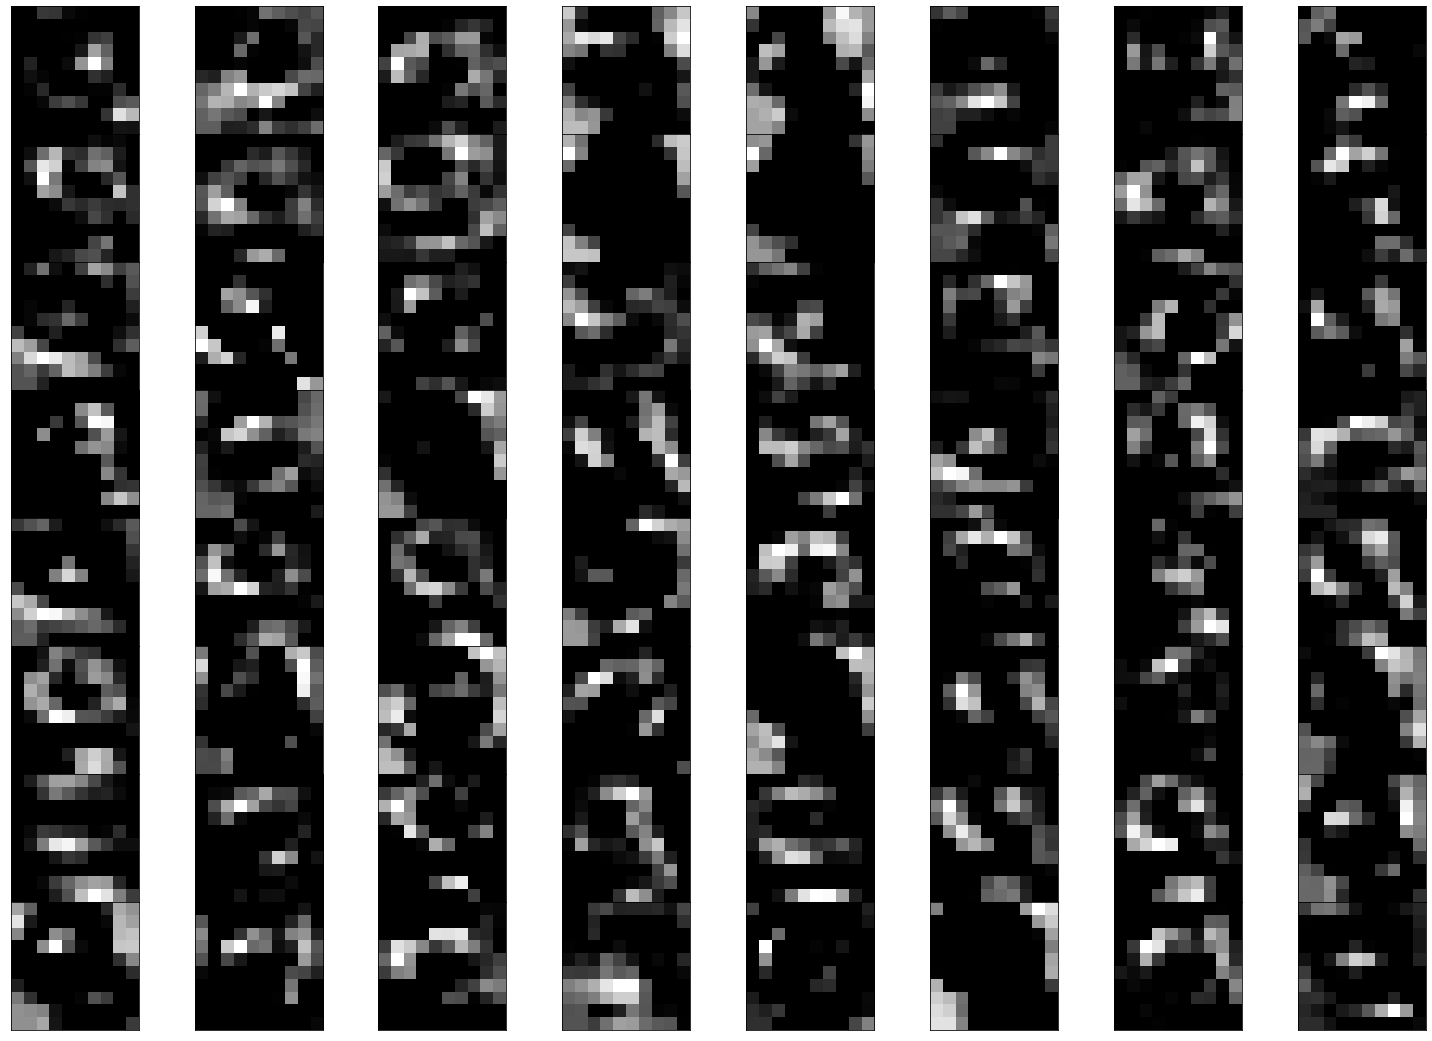

In [119]:
conv_out = Layer_Hook(model.layer3)
img, label = test_dataset[151]
label = torch.from_numpy(np.array(label))   # load the testing data
img = img.view(1,1,28,28)    
out = model(img.to(device))
conv_out.remove()
act = conv_out.features
num = conv_out.count
cols = 8

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0, wspace=0.2)
for i in range(num):
    ax = fig.add_subplot(int(num/cols)+1, cols, i+1, xticks=[], yticks=[])
    ax.imshow(act[0][i].cpu().detach().numpy(), cmap='gray')

In [91]:
act[0].shape

torch.Size([1024])

In [122]:
torch.save(model.state_dict(), './model_state1.pth')

In [12]:
X = torch.rand((2,1,28,28)).to(device)
for name, layer in model.named_children():
    X = layer(X)
    print(name, 'shape:', X.shape)

layer1 shape: torch.Size([2, 16, 26, 26])
layer2 shape: torch.Size([2, 32, 12, 12])
layer3 shape: torch.Size([2, 64, 10, 10])
layer4 shape: torch.Size([2, 128, 4, 4])


RuntimeError: size mismatch, m1: [1024 x 4], m2: [2048 x 1024] at C:/w/1/s/windows/pytorch/aten/src\THC/generic/THCTensorMathBlas.cu:290